## imports

In [33]:
from pprint import pprint
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    classification_report,
)
from sklearn.linear_model import LogisticRegression

from data_viz_functions import *

In [2]:
data = pd.read_csv("dataset.csv")
train, validation = train_test_split(data, test_size=0.33, random_state=42)


## first view

In [3]:
data.shape


(73799, 14)

## общий вид

In [4]:
data.dtypes


client_id            int64
education           object
sex                 object
age                  int64
car                 object
car_type            object
decline_app_cnt      int64
good_work            int64
bki_request_cnt      int64
home_address         int64
work_address         int64
income               int64
foreign_passport    object
default              int64
dtype: object

In [5]:
data.sample(10)


,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
2558,64823,GRD,M,25,N,N,0,0,2,2,3,92000,N,0
48390,13647,SCH,M,28,N,N,0,1,1,1,2,27000,N,0
30300,26280,SCH,M,30,N,N,0,0,1,2,3,24000,N,0
23842,98084,UGR,M,35,Y,N,0,0,2,2,3,60000,N,0
63825,33761,UGR,M,35,Y,Y,0,0,1,2,3,40000,N,0
37486,85468,SCH,F,30,Y,N,0,0,2,2,3,30000,N,0
17271,27011,GRD,M,43,Y,Y,0,0,5,1,2,50000,N,0
46628,25391,SCH,F,48,N,N,0,0,0,2,3,40000,N,0
409,72143,SCH,M,53,N,N,0,0,2,1,2,25000,N,0
37500,18565,SCH,M,59,N,N,0,0,3,1,2,60000,N,0


### цифровые

по факту следующие цифровые переменные также стоит считать категориальными:

- home_address
- work_address
- good_work
- default

In [6]:
describe_nums(
    data.drop(["client_id", "income", "age"], axis="columns").select_dtypes("int64")
)


,unique,n/a count,count,mean,std,min,25%,50%,75%,max
bki_request_cnt,38,0,73799.000000,2.000339,2.252073,0.000000,0.000000,1.000000,3.000000,53.000000
decline_app_cnt,21,0,73799.000000,0.275749,0.804272,0.000000,0.000000,0.000000,0.000000,33.000000
home_address,3,0,73799.000000,1.575509,0.527631,1.000000,1.000000,2.000000,2.000000,3.000000
work_address,3,0,73799.000000,2.496280,0.689818,1.000000,2.000000,3.000000,3.000000,3.000000
good_work,2,0,73799.000000,0.164894,0.371087,0.000000,0.000000,0.000000,0.000000,1.000000
default,2,0,73799.000000,0.126994,0.332968,0.000000,0.000000,0.000000,0.000000,1.000000


### категориальные

In [7]:
data.select_dtypes("object").describe().T.sort_values("freq", ascending=False)


,count,unique,top,freq
foreign_passport,73799,2,N,62733
car_type,73799,2,N,59791
car,73799,2,N,49832
sex,73799,2,F,41562
education,73492,5,SCH,38860


In [8]:
data.work_address.unique().tolist(), data.home_address.unique().tolist()


([2, 3, 1], [1, 2, 3])

### делим на списки

In [9]:
nums = ["income", "age", "bki_request_cnt", "decline_app_cnt"]
cats = [
    "home_address",
    "work_address",
    "good_work",
    "default",
    "foreign_passport",
    "car_type",
    "car",
    "sex",
    "education",
]


### деление в задании

In [10]:
# бинарные переменные
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]

# категориальные переменные
cat_cols = ["education", "work_address", "home_address"]

# числовые переменные

num_cols = ["age", "decline_app_cnt", "bki_request_cnt", "income"]


### корреляция числовых переменных

они почти не скоррелированы, что неплохо для нас, не надо избавляться от мультиколлинеарности

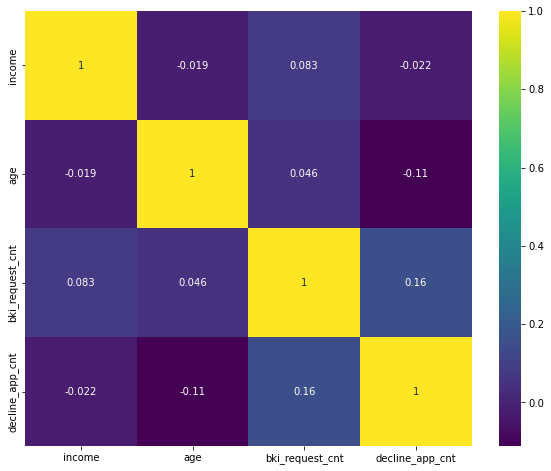

In [11]:
plt.subplots(figsize=(10, 8))
sns.heatmap(data[nums].corr(), cmap="viridis", annot=True)
plt.show()


## preprocessing

### значимость числовых призников

<AxesSubplot:>

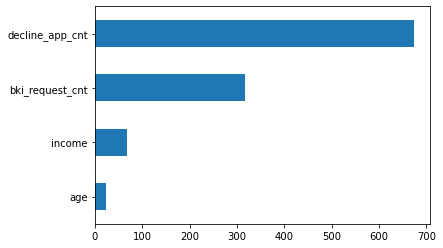

In [12]:
imp_num = pd.Series(f_classif(train[num_cols], train["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind="barh")


### label encoding

Почему мы применили метод только к бинарным переменным? Единственным минусом использования кодирования при помощи LabelEncoder() является то, что при использовании этого подхода мы должны быть уверены, что признак не может принимать неизвестных ранее значений. 

In [13]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    validation[column] = label_encoder.fit_transform(validation[column])

# убедимся в преобразовании
train.head()


,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
8931,104346,GRD,0,27,0,0,0,0,3,2,3,30000,0,0
63915,56248,GRD,0,47,0,0,0,0,4,1,2,20000,0,0
45568,59433,SCH,0,47,0,0,0,0,0,2,3,45000,0,0
3391,21096,SCH,0,32,0,0,0,0,3,2,3,21000,0,1
40660,18878,SCH,0,31,0,0,0,1,6,2,3,30000,1,0


In [14]:
train["education"].unique().tolist()


['GRD', 'SCH', 'UGR', 'PGR', 'ACD', nan]

In [15]:
train["education"] = train["education"].map(
    {"GRD": 1, "SCH": 2, "UGR": 3, "PGR": 4, "ACD": 5, np.nan: 6}
)

validation["education"] = validation["education"].map(
    {"GRD": 1, "SCH": 2, "UGR": 3, "PGR": 4, "ACD": 5, np.nan: 6}
)


### значимость категориальных признаков

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

<AxesSubplot:>

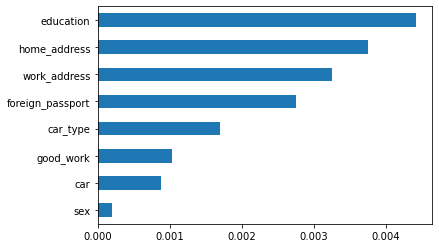

In [16]:
imp_cat = pd.Series(
    mutual_info_classif(
        train[bin_cols + cat_cols], train["default"], discrete_features=True
    ),
    index=bin_cols + cat_cols,
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind="barh")


### one hot encoder

In [17]:
X_cat_train = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
X_cat_validation = OneHotEncoder(sparse=False).fit_transform(validation[cat_cols].values)


In [18]:
X_cat_train.shape, X_cat_validation


((49445, 12),
 array([[0., 0., 1., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 1., 0., 0.]]))

### стандартизируем

In [19]:
X_num_train = StandardScaler().fit_transform(train[num_cols].values)
X_num_validation = StandardScaler().fit_transform(validation[num_cols].values)

X_train = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y_train = train["default"].values

X_validation = np.hstack([X_num_validation, validation[bin_cols].values, X_cat_validation])
y_validation = validation["default"].values

## углубляемся в переменные

фича education

In [20]:
data.education.fillna("NA", inplace=True)


In [21]:
data.education.value_counts().to_frame()


,education
SCH,38860
GRD,23365
UGR,9816
PGR,1257
NA,307
ACD,194


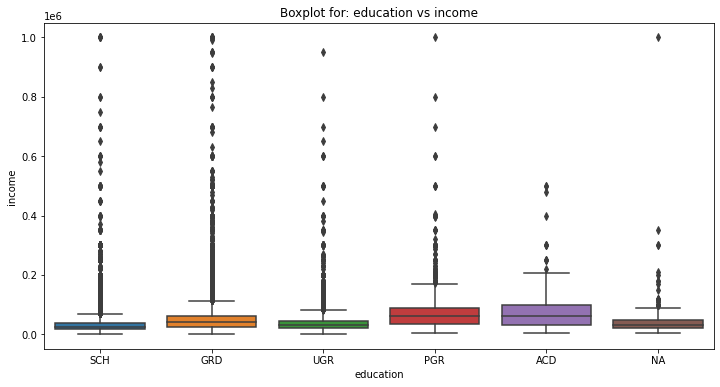

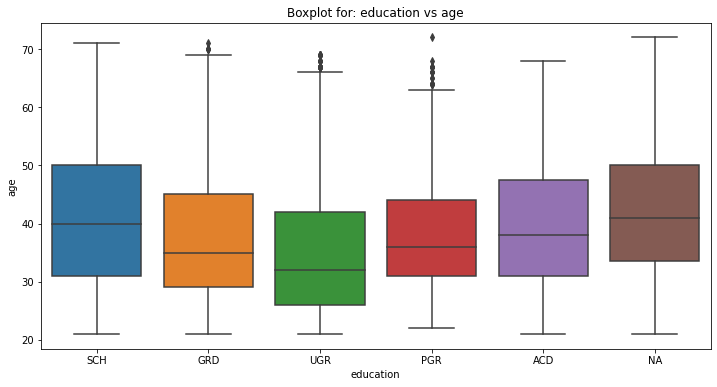

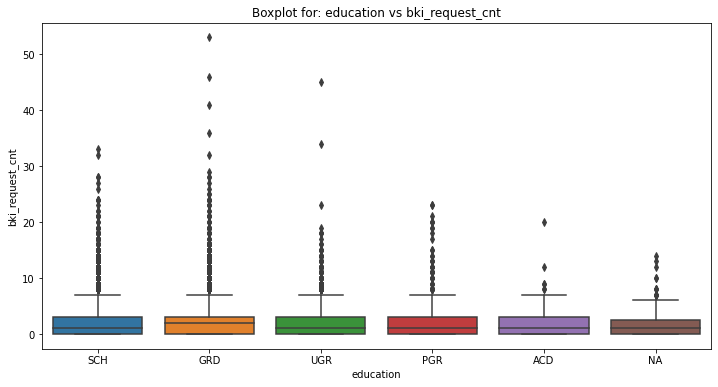

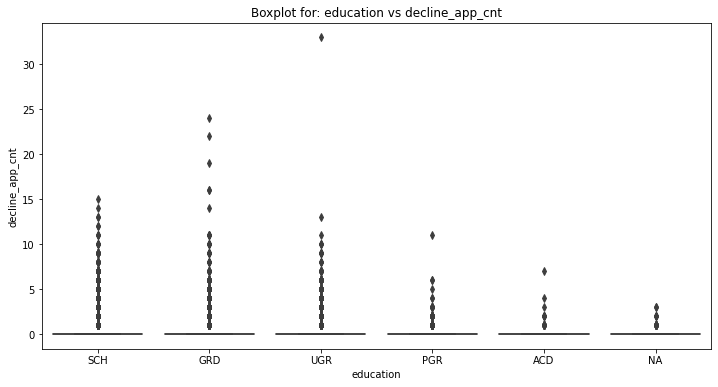

In [22]:
for n in nums:
    show_boxplots(data, "education", n)


логорифмируем

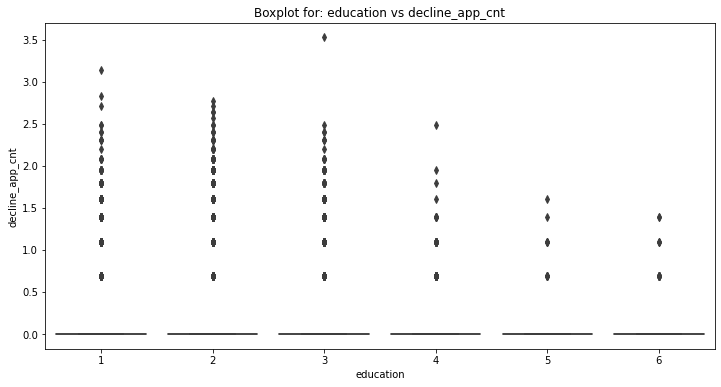

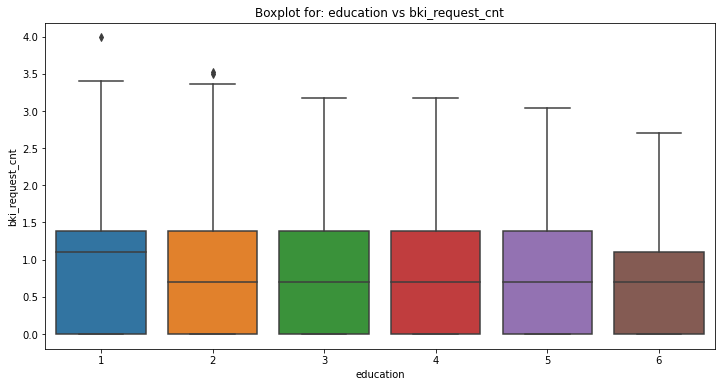

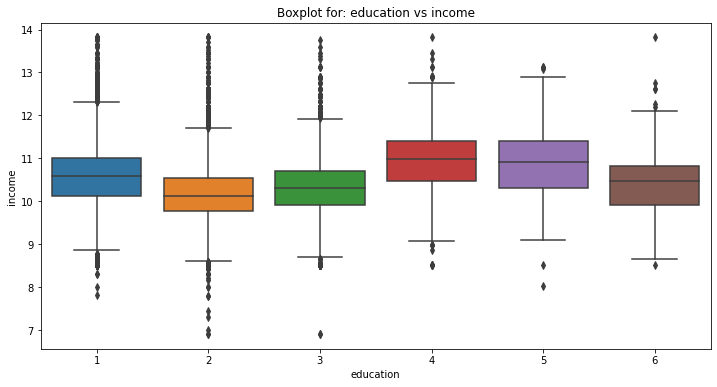

In [23]:
# большие хвосты, надо отлогорифмировать числовые переменные, кроме возможно возраста
# обратная операция делается с помощью np.exp на вектор целиком

for n in ["decline_app_cnt", "bki_request_cnt", "income"]:
    train[n] = train[n].apply(lambda w: np.log(w + 1))
    validation[n] = validation[n].apply(lambda w: np.log(w + 1))
    show_boxplots(train, "education", n)


фича default

In [24]:
data.default.value_counts().to_frame()


,default
0,64427
1,9372


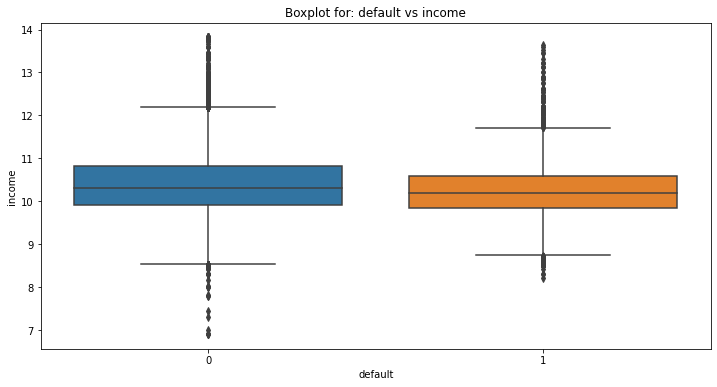

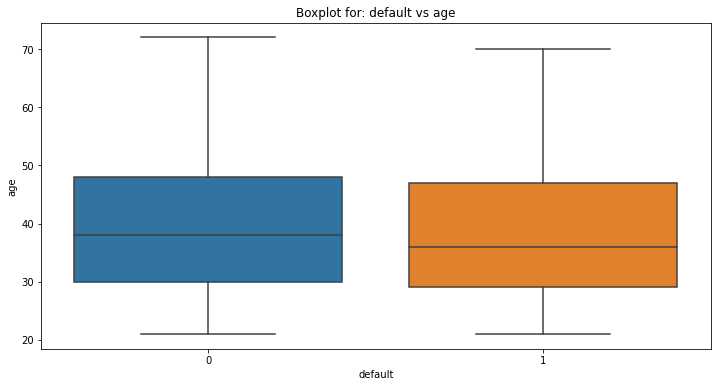

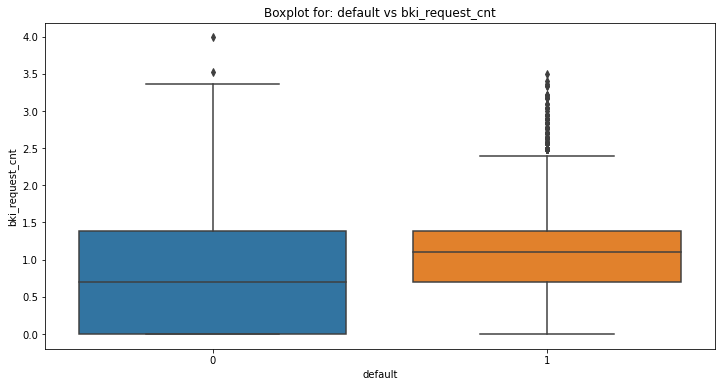

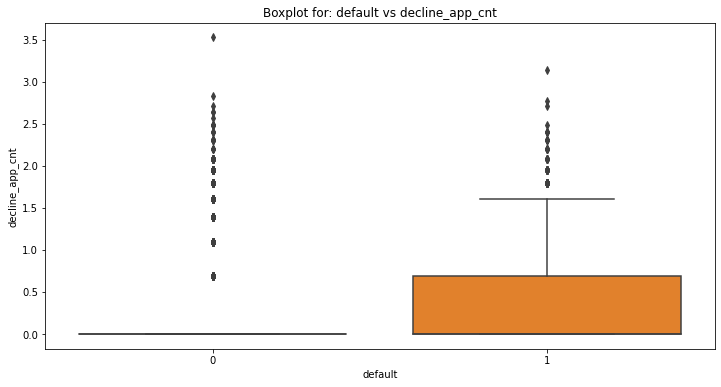

In [25]:
for n in nums:
    show_boxplots(train, "default", n)


фича age

Unique values count: 52 
Q1: 30.0
Q3: 48.0
IQR: 18.0 
Outliers borders: [3.0, 75.0]


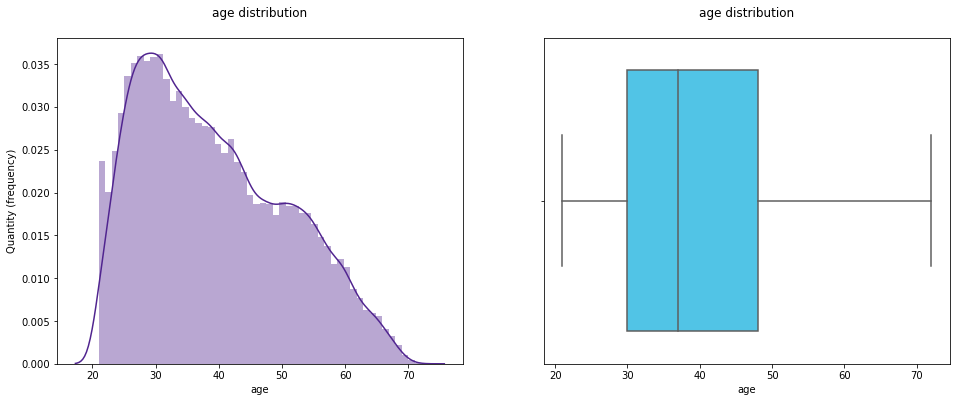

In [26]:
show_IQR(data.age)


фича income

Unique values count: 966 
Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Outliers borders: [-22000.0, 90000.0]


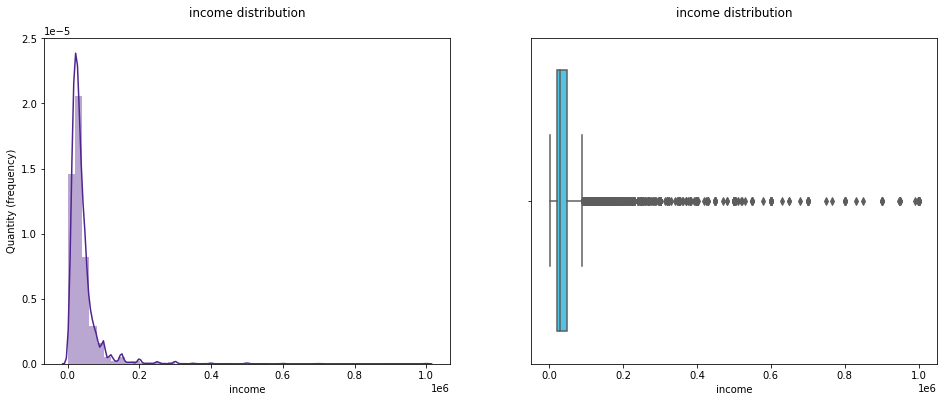

In [27]:
show_IQR(data.income)


## оценка качества модели

model

In [28]:
model = LogisticRegression().fit(X_train, y_train)

In [29]:
y_pred_on_train = model.predict(X_train)
y_pred_on_validation = model.predict(X_validation)

[confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

In [30]:
TN, FP, FN, TP = confusion_matrix(y_train, y_pred_on_train).ravel()
TN, FP, FN, TP

(43054, 79, 6260, 52)

In [31]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)

# Specificity or true negative rate
TNR = TN / (TN + FP)

# Precision or positive predictive value
PPV = TP / (TP + FP)

# Negative predictive value
NPV = TN / (TN + FN)

# Fall out or false positive rate
FPR = FP / (FP + TN)

# False negative rate
FNR = FN / (TP + FN)

# False discovery rate
FDR = FP / (TP + FP)

# Overall accuracy
ACC = (TP + TN) / (TP + FP + FN + TN)

roc_auc and classification report

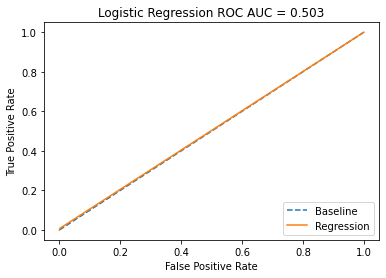

['              precision    recall  f1-score   support',
 '',
 '           0       0.87      1.00      0.93     43133',
 '           1       0.40      0.01      0.02      6312',
 '',
 '    accuracy                           0.87     49445',
 '   macro avg       0.64      0.50      0.47     49445',
 'weighted avg       0.81      0.87      0.81     49445',
 '']


In [32]:
show_classification_details(y_train, y_pred_on_train)

## model tuning

gridsearch

In [34]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {
        "penalty": ["l1"],
        "solver": ["liblinear", "lbfgs"],
        "class_weight": ["none", "balanced"],
        "multi_class": ["auto", "ovr"],
        "max_iter": [iter_],
        "tol": [epsilon_stop],
    },
    {
        "penalty": ["l2"],
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
        "class_weight": ["none", "balanced"],
        "multi_class": ["auto", "ovr"],
        "max_iter": [iter_],
        "tol": [epsilon_stop],
    },
    {
        "penalty": ["none"],
        "solver": ["newton-cg", "lbfgs", "sag", "saga"],
        "class_weight": ["none", "balanced"],
        "multi_class": ["auto", "ovr"],
        "max_iter": [iter_],
        "tol": [epsilon_stop],
    },
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


/home/user/opt/mambaforge/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/opt/mambaforge/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False


model with new params

In [35]:
model = LogisticRegression(
    class_weight="balanced",
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    max_iter=50,
    multi_class="ovr",
    n_jobs=None,
    penalty="l2",
    random_state=None,
    solver="saga",
    tol=0.001,
    verbose=0,
    warm_start=False,
).fit(X_train, y_train)

In [36]:
y_pred_on_train = model.predict(X_train)
y_pred_on_validation = model.predict(X_validation)

roc_auc tuned

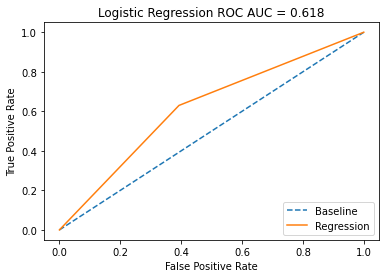

['              precision    recall  f1-score   support',
 '',
 '           0       0.92      0.61      0.73     43133',
 '           1       0.19      0.63      0.29      6312',
 '',
 '    accuracy                           0.61     49445',
 '   macro avg       0.55      0.62      0.51     49445',
 'weighted avg       0.83      0.61      0.67     49445',
 '']


In [37]:
show_classification_details(y_train, y_pred_on_train)